# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [570]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
import censusgeocode as cg
import pickle


sns.set(style="darkgrid")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [571]:
df = pd.read_csv("kc_house_data_train.csv", index_col="Unnamed: 0")

In [572]:
print(df.columns)
ignore_cols = ['id', 'price', 'date']
explore_cols = [x for x in df.columns if x not in ignore_cols]

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [573]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df[explore_cols].values, i) for i in range(df[explore_cols].shape[1])]
vif["features"] = df[explore_cols].columns
vif.round(1)

/Users/browz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,22.5,bedrooms
1,28.4,bathrooms
2,inf,sqft_living
3,2.3,sqft_lot
4,16.8,floors
5,1.2,waterfront
6,1.6,view
7,34.5,condition
8,147.9,grade
9,inf,sqft_above


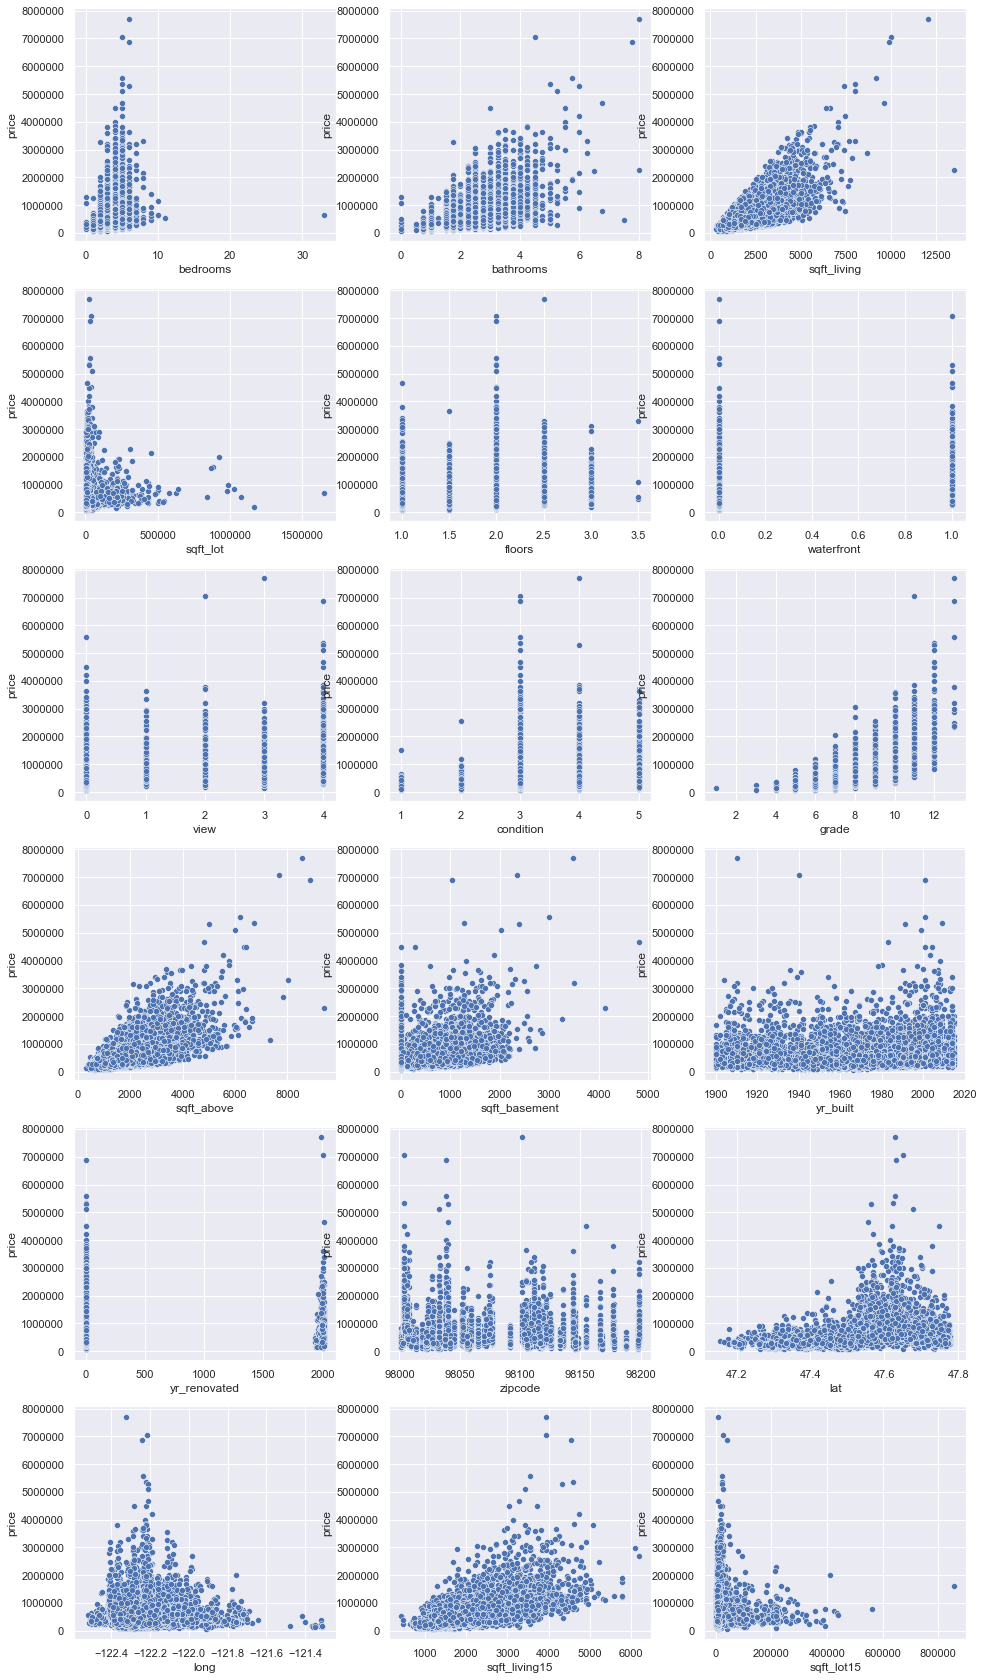

In [574]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,30))

for i, column in enumerate(explore_cols):
    sns.scatterplot(data = df, x=column,y='price', ax=axes[i//3, i%3])

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [575]:
df['shack_living'] = np.where(df['sqft_living']/df['sqft_lot'] < .2, 1, 0)

In [576]:
df['bedrooms'].iloc[483] = 4 
df['bathrooms'].iloc[483] =  2.5
df['bedrooms'].iloc[1120] = 5
df['bathrooms'].iloc[1120] =  4
df['bedrooms'].iloc[3032] = 3
df['bathrooms'].iloc[3032] = 1.5
df['bedrooms'].iloc[3609] = 4
df['bathrooms'].iloc[3609] = 3
df['bedrooms'].iloc[5424] = 3
df['bathrooms'].iloc[5424] = 3
df['bedrooms'].iloc[6409] = 3
df['bathrooms'].iloc[6409] = 2
df['bedrooms'].iloc[9286] = 4
df['bathrooms'].iloc[9286] = 4.5
df['bedrooms'].iloc[10074] = 4
df['bathrooms'].iloc[10074] = 2.5
df['bedrooms'].iloc[15733] = 3
df['bathrooms'].iloc[15733] = 2.5

df.drop(index=[9060,12982,13989,10067,2430], inplace=True)

/Users/browz/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [577]:
df['bedrooms'] = df['bedrooms'].replace({11:4, 33:3})

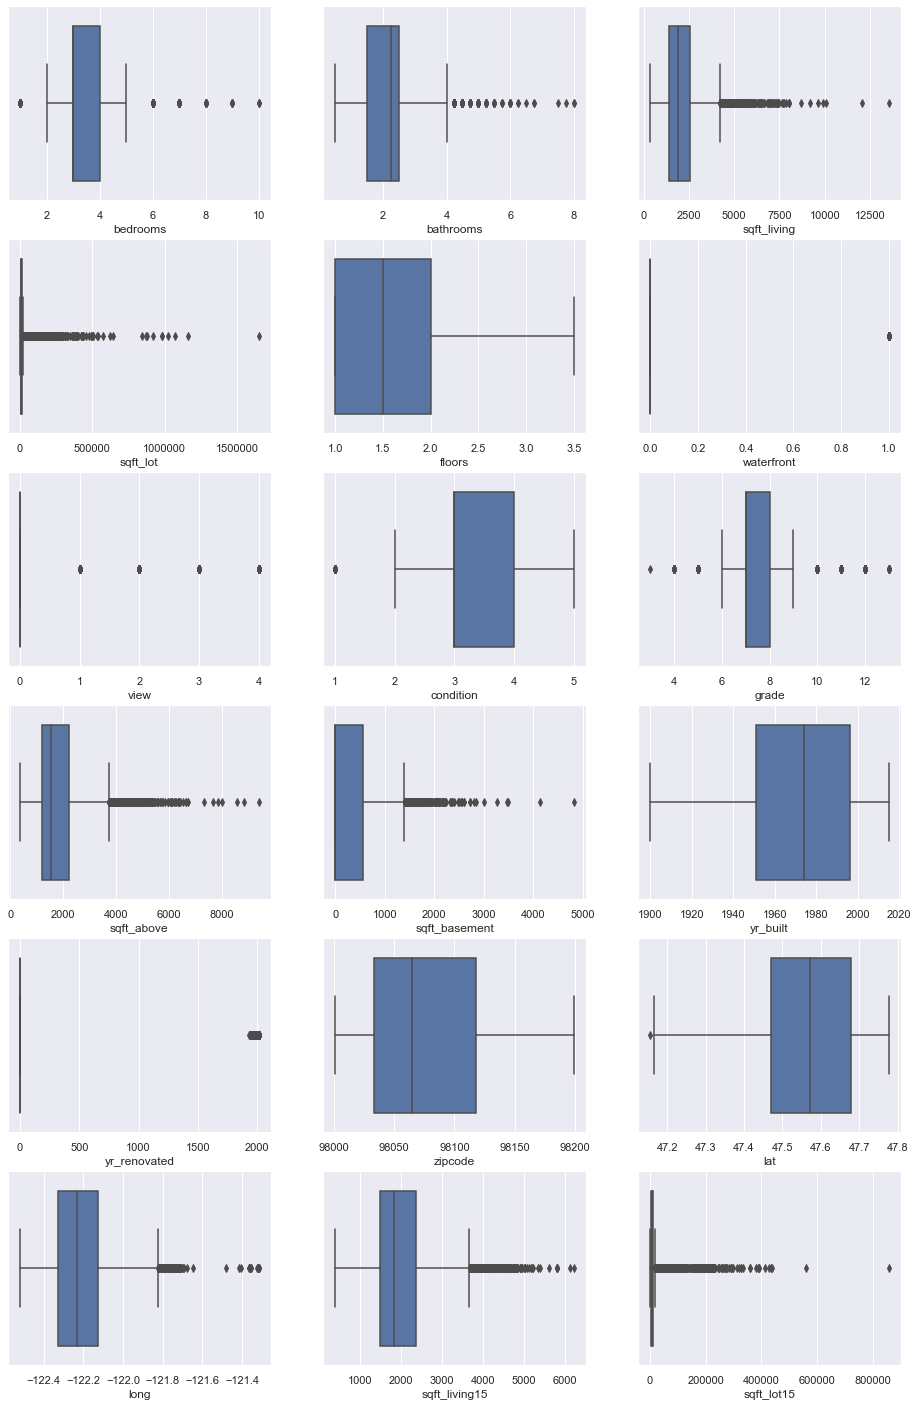

In [578]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16,25))

for i, column in enumerate(explore_cols):
    sns.boxplot(data = df, x=column, ax=axes[i//3, i%3])

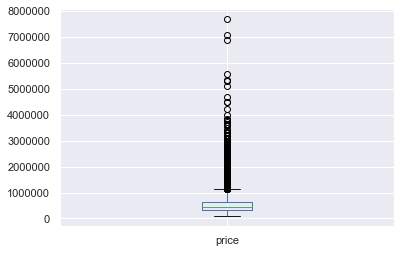

In [579]:
df.price.plot.box()

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [580]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'shack_living'],
      dtype='object')

In [581]:
df['yrs_old'] = 2020-df.yr_built

In [582]:
df['age_feature'] = (df['yrs_old'] - 57)**2
df['grade_exp'] = np.exp(df['grade'])

In [583]:
conditions = [df['condition']<= 2, df['condition'].isin(range(3, 5)), df['condition'] == 5]
choices = ['busted', 'aight', 'dope']

df['cond_cat'] = np.select(conditions, choices, default = 'missing')

In [584]:
df['has_basement'] = np.where(df['sqft_basement'] == 0, 0, 1)

In [585]:
df['date'] = pd.to_datetime(df['date'], format="%Y%m%dT000000")
df['season'] = (df.date.dt.month%12 + 3)//3

In [586]:
df['grade_exp'] = np.exp(df['grade'])

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [587]:
season_dum = pd.get_dummies(df['season'], prefix='sn', drop_first=True)
zipcode_dum = pd.get_dummies(df['zipcode'], prefix='zp', drop_first=True)
cond_dum = pd.get_dummies(df['cond_cat'], prefix='condtn', drop_first=True)
df = pd.concat([df, cond_dum, zipcode_dum, season_dum], 1)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [588]:
#your code here 
df['last_const'] = np.where(df['yr_renovated']==0, 2020-df['yr_built'],2020-df['yr_renovated'])

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [589]:
df.condtn_dope.value_counts()

0    15918
1     1367
Name: condtn_dope, dtype: int64

## Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [590]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view',
       ...
       'zp_98168', 'zp_98177', 'zp_98178', 'zp_98188', 'zp_98198', 'zp_98199',
       'sn_2', 'sn_3', 'sn_4', 'last_const'],
      dtype='object', length=103)

In [591]:
leave_out = ['id', 'date', 'season', 'price', 'cond_cat', 'sqft_lot', 
             'floors', 'view', 'condition', 'grade', 'sqft_above', 
             'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'last_const']
features = [x for x in df.columns if x not in leave_out] 
print(features)

['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'sqft_lot15', 'shack_living', 'yrs_old', 'age_feature', 'grade_exp', 'has_basement', 'condtn_busted', 'condtn_dope', 'zp_98002', 'zp_98003', 'zp_98004', 'zp_98005', 'zp_98006', 'zp_98007', 'zp_98008', 'zp_98010', 'zp_98011', 'zp_98014', 'zp_98019', 'zp_98022', 'zp_98023', 'zp_98024', 'zp_98027', 'zp_98028', 'zp_98029', 'zp_98030', 'zp_98031', 'zp_98032', 'zp_98033', 'zp_98034', 'zp_98038', 'zp_98039', 'zp_98040', 'zp_98042', 'zp_98045', 'zp_98052', 'zp_98053', 'zp_98055', 'zp_98056', 'zp_98058', 'zp_98059', 'zp_98065', 'zp_98070', 'zp_98072', 'zp_98074', 'zp_98075', 'zp_98077', 'zp_98092', 'zp_98102', 'zp_98103', 'zp_98105', 'zp_98106', 'zp_98107', 'zp_98108', 'zp_98109', 'zp_98112', 'zp_98115', 'zp_98116', 'zp_98117', 'zp_98118', 'zp_98119', 'zp_98122', 'zp_98125', 'zp_98126', 'zp_98133', 'zp_98136', 'zp_98144', 'zp_98146', 'zp_98148', 'zp_98155', 'zp_98166', 'zp_98168', 'zp_98177', 'zp_98178', 'zp_98188', 'zp_98198', 'zp_98199', 

In [592]:
#your code here 
X_train, X_test, y_train, y_test = train_test_split(df[features], df['price'], random_state=57,test_size=0.2)

print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (13828, 84) Target:  (13828,)
Training set - Features:  (3457, 84) Target:  (3457,)


### 5.2) Fit your scaler to training the data.

In [593]:
scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

### 5.3) Transform the testing set with the scaler.

In [594]:
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=df[features].columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df[features].columns)

### 5.4) Fit the model to the training data.

In [595]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

### 5.5) Use the model to predict on the training set and the test set.

In [596]:
y_train_pred = lm.predict(X_train)

y_test_pred = lm.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [597]:
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

### 5.7) Determine if your model is overfit.

In [598]:
print(f'Training: {int(train_rmse)} vs Testing: {int(test_rmse)}')

Training: 157100 vs Testing: 165603


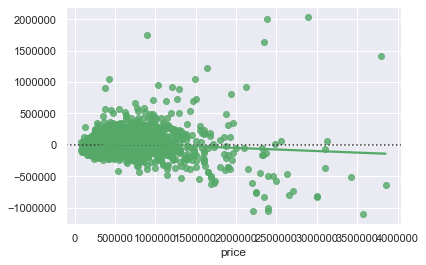

In [599]:
sns.residplot(x = y_test, y= y_test_pred, lowess=True, color = "g")

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [600]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df[features])
poly2_columns = poly_2.get_feature_names(df[features].columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)

In [601]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, df['price'], random_state=27,test_size=0.2)

In [602]:
scaler2 = StandardScaler()

scaler2.fit(X_train)

X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_poly2.columns)

X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_poly2.columns)

In [603]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train, y_train)

y_train_pred = lm_2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

In [604]:
y_pred = lm_2.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Training:  110672 vs. Testing:  115221878568455792


In [605]:
bad_ind = abs(y_test-y_pred).sort_values(ascending=False).index
abs(y_test-y_pred).sort_values(ascending=False)

10593    4.873254e+18
2016     4.705028e+18
7671     5.834024e+16
9064     5.834024e+16
5230     5.120866e+16
             ...     
13266    1.440367e+02
15351    8.903667e+01
5414     7.496333e+01
13222    5.096333e+01
4854     1.503667e+01
Name: price, Length: 3457, dtype: float64

In [606]:
df.shack_living.value_counts()

0    10784
1     6501
Name: shack_living, dtype: int64

In [607]:
df.loc[bad_ind][:10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,shack_living,yrs_old,age_feature,grade_exp,cond_cat,has_basement,season,condtn_busted,condtn_dope,zp_98002,zp_98003,zp_98004,zp_98005,zp_98006,zp_98007,zp_98008,zp_98010,zp_98011,zp_98014,zp_98019,zp_98022,zp_98023,zp_98024,zp_98027,zp_98028,zp_98029,zp_98030,zp_98031,zp_98032,...,zp_98039,zp_98040,zp_98042,zp_98045,zp_98052,zp_98053,zp_98055,zp_98056,zp_98058,zp_98059,zp_98065,zp_98070,zp_98072,zp_98074,zp_98075,zp_98077,zp_98092,zp_98102,zp_98103,zp_98105,zp_98106,zp_98107,zp_98108,zp_98109,zp_98112,zp_98115,zp_98116,zp_98117,zp_98118,zp_98119,zp_98122,zp_98125,zp_98126,zp_98133,zp_98136,zp_98144,zp_98146,zp_98148,zp_98155,zp_98166,zp_98168,zp_98177,zp_98178,zp_98188,zp_98198,zp_98199,sn_2,sn_3,sn_4,last_const
10593,5154200015,2015-04-14,1705000.0,3,3.00,2490,27702,2.0,1,4,3,10,2490,0,2000,0,98116,47.5596,-122.403,2580,12119,1,20,1369,22026.465795,aight,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,20
2016,7403200050,2014-11-13,1600000.0,3,2.25,3370,23065,1.0,1,4,3,10,1920,1450,1980,0,98028,47.7434,-122.263,3410,19688,1,40,289,22026.465795,aight,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,40
7671,324059112,2015-03-25,675500.0,4,2.75,2060,21344,1.0,0,0,2,8,1460,600,1978,0,98005,47.5934,-122.154,2060,16088,1,42,225,2980.957987,busted,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,42
9064,6205500030,2014-11-03,480000.0,4,2.00,2180,10575,1.0,0,0,2,6,1730,450,1950,0,98005,47.5890,-122.177,2180,12010,0,70,169,403.428793,busted,1,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,70
5230,5152600090,2014-07-08,235500.0,5,2.50,2340,13713,1.0,0,0,2,8,1670,670,1967,0,98003,47.3307,-122.324,2080,11000,1,53,16,2980.957987,busted,1,3,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,53
3318,1771100330,2014-06-05,250000.0,3,2.50,1510,10384,1.0,0,0,2,7,1030,480,1976,0,98077,47.7580,-122.071,1490,10000,1,44,169,1096.633158,busted,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,44
16348,7802900224,2014-07-07,670000.0,5,2.50,2860,68519,2.0,0,0,5,8,2860,0,1958,0,98065,47.5265,-121.835,1670,35910,1,62,25,2980.957987,dope,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,62
11817,6073300040,2015-01-06,375000.0,4,2.25,2020,12500,2.0,0,0,2,8,2020,0,1966,0,98056,47.5403,-122.175,1800,13175,1,54,9,2980.957987,busted,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54
17111,4045500510,2014-05-21,420850.0,1,1.00,960,40946,1.0,0,0,5,5,960,0,1945,0,98014,47.6951,-121.864,1320,20350,1,75,324,148.413159,dope,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,75
6667,4139900180,2015-04-20,2340000.0,4,2.50,4500,35200,1.0,0,0,3,13,4500,0,1988,0,98006,47.5477,-122.126,4760,35200,1,32,625,442413.392009,aight,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,32


In [608]:
y_test[6667]-y_pred[1187]

1738530.963329115

### Feature Selection

### Lasso

In [609]:
lasso = Lasso(alpha=750, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse_lasso01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01))
print('Testing Error: '+ str(test_rmse_lasso01))

Training Error: 72501.66537067466
Testing Error: 154413.98204191742


In [610]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1, normalize=False)

ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
y_pred = ridge.predict(X_test)

train_rmse_ridge01 = metrics.mean_absolute_error(y_train, y_train_pred)
test_rmse_ridge01 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse_lasso01))
print('Testing Error: '+ str(test_rmse_lasso01))
ridge.coef_

Training Error: 72501.66537067466
Testing Error: 154413.98204191742


array([13057.33539782, 16111.84787044, 71644.34439607, ...,
       -8591.77013028,     0.        , -9476.9658153 ])

## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [611]:
pickle_out = open("model.pickle", 'wb')
pickle.dump(ridge, pickle_out)
pickle_out.close()

In [612]:
pickle_out = open("scaler.pickle", "wb")
pickle.dump(scaler2, pickle_out)
pickle_out.close()